In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import Product Sales and Weather Data (Mel/Syd)
sales_df = pd.read_csv("../data/ProductsByDate.csv")
weather_mel_df = pd.read_csv("../data/weather_data_mel.csv")
weather_syd_df = pd.read_csv("../data/weather_data_syd.csv")

sales_df.head()
weather_mel_df.head()
weather_syd_df.head()

,date,temperature,humidity,wind_speed
0,03/01/2023,27.82,63.0,14.92
1,23/01/2023,24.83,68.0,8.75
2,26/01/2023,30.94,58.0,9.26
3,29/01/2023,29.70,73.0,8.75
4,01/02/2023,27.28,64.0,9.26


In [7]:
# Parse dates
sales_df['Date'] = pd.to_datetime(sales_df['order_date'], format='%d/%m/%Y') 
weather_mel_df['Date'] = pd.to_datetime(weather_mel_df['date'], format='%d/%m/%Y')
weather_syd_df['Date'] = pd.to_datetime(weather_syd_df['date'], format='%d/%m/%Y')

# Add Month and Season
sales_df['Month'] = sales_df['Date'].dt.month
sales_df['Year'] = sales_df['Date'].dt.year
def map_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

sales_df['Season'] = sales_df['Month'].apply(map_season)

# Group by Month and Product
monthly_sales = sales_df.groupby(['Month', 'product_category'])['quantity_sold'].sum().reset_index()

monthly_sales.head()

,Month,product_category,quantity_sold
0,1,Cold and Flu,676
1,1,Cosmetics,165
2,1,Hair Care,545
3,1,Hayfever,3300
4,2,Cold and Flu,627


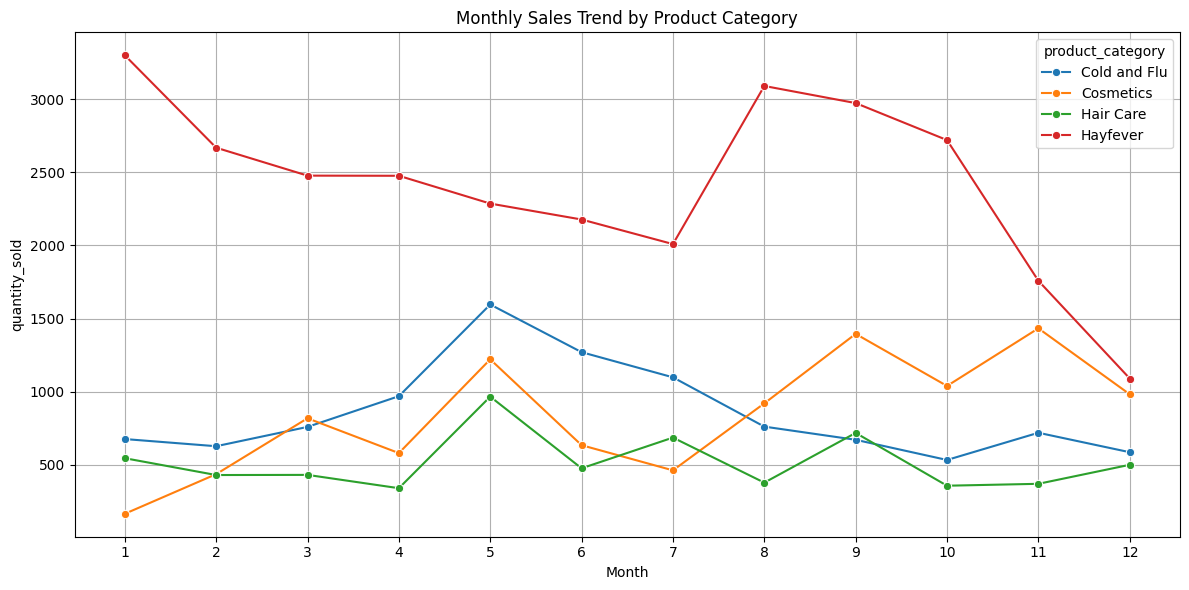

In [8]:
# Insight 1: Product-wise Monthly Sales Trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='quantity_sold', hue='product_category', marker='o')
plt.title('Monthly Sales Trend by Product Category')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

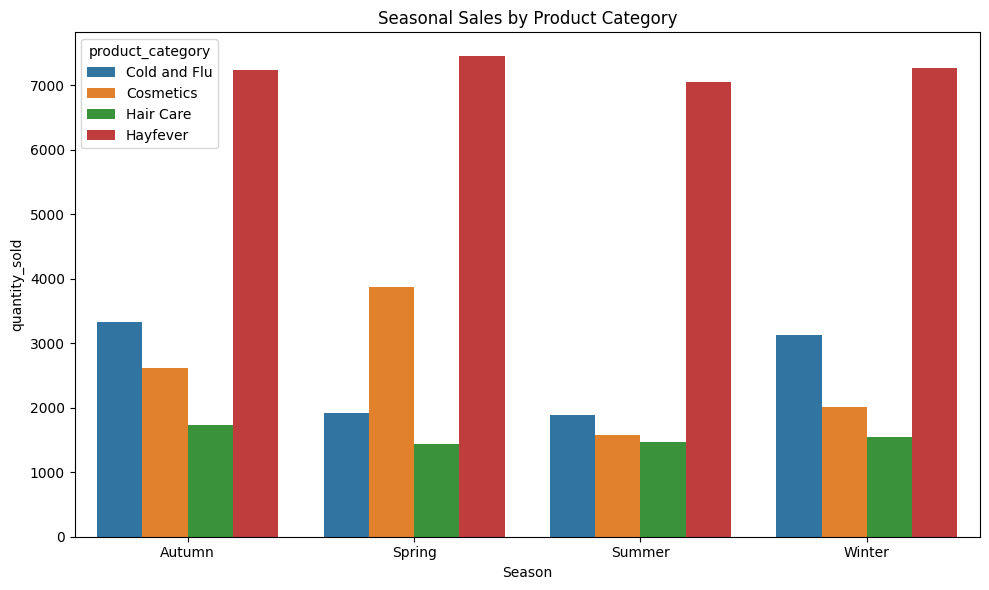

In [9]:
# Insight 2: Total sales by season
seasonal_sales = sales_df.groupby(['Season', 'product_category'])['quantity_sold'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=seasonal_sales, x='Season', y='quantity_sold', hue='product_category')
plt.title('Seasonal Sales by Product Category')
plt.tight_layout()
plt.show()

In [11]:
# Merge weather data with product data based on date
mel_combined = pd.merge(sales_df, weather_mel_df, how="inner", left_on="order_date", right_on="date")
mel_combined.drop(columns=["date"])
syd_combined = pd.merge(sales_df, weather_syd_df, how="inner", left_on="order_date", right_on="date")
syd_combined.drop(columns=["date"])

mel_combined.head()
syd_combined.head()

,order_date,product_id,product_category,quantity_sold,Date_x,Month,Year,Season,date,temperature,humidity,wind_speed,Date_y
0,23/01/2023,2490971,Cold and Flu,22,2023-01-23,1,2023,Summer,23/01/2023,24.83,68.0,8.75,2023-01-23
1,26/01/2023,2490971,Cold and Flu,15,2023-01-26,1,2023,Summer,26/01/2023,30.94,58.0,9.26,2023-01-26
2,29/01/2023,2490971,Cold and Flu,12,2023-01-29,1,2023,Summer,29/01/2023,29.70,73.0,8.75,2023-01-29
3,24/02/2023,2490971,Cold and Flu,14,2023-02-24,2,2023,Summer,24/02/2023,24.98,62.0,8.23,2023-02-24
4,27/02/2023,2490971,Cold and Flu,16,2023-02-27,2,2023,Summer,27/02/2023,25.67,73.0,9.26,2023-02-27


In [20]:
# Function to calculate correlation by season
def correlation_by_season(df, city_name):
    print(f"\nCorrelations for {city_name}")
    for season in df["Season"].unique():
        print(f"\nSeason: {season}")
        season_df = df[df["Season"] == season]

        for category in season_df["product_category"].unique():
            category_df = season_df[season_df["product_category"] == category]

            # Ensure enough data and variation exists
            subset = category_df[["quantity_sold", "temperature", "humidity", "wind_speed"]]
            if len(subset) >= 2 and subset.std().min() > 0:
                corr = subset.corr()
                print(f"\nProduct Category: {category}")
                print(corr["quantity_sold"][1:])  # Correlation with each weather variable
            else:
                print(f"\nProduct Category: {category}")
                print("Not enough data or variation to compute correlation.")

# Calculate correlations
correlation_by_season(mel_combined, "Melbourne")
correlation_by_season(syd_combined, "Sydney")


Correlations for Melbourne

Season: Summer

Product Category: Cold and Flu
temperature   -0.039200
humidity       0.085389
wind_speed     0.053350
Name: quantity_sold, dtype: float64

Product Category: Hayfever
temperature    0.175852
humidity      -0.041871
wind_speed    -0.135276
Name: quantity_sold, dtype: float64

Product Category: Hair Care
temperature   -0.336097
humidity       0.365266
wind_speed    -0.179821
Name: quantity_sold, dtype: float64

Product Category: Cosmetics
temperature   -0.190158
humidity       0.256476
wind_speed     0.009340
Name: quantity_sold, dtype: float64

Season: Autumn

Product Category: Cold and Flu
temperature   -0.300276
humidity       0.106923
wind_speed     0.081134
Name: quantity_sold, dtype: float64

Product Category: Hayfever
temperature    0.089934
humidity      -0.009519
wind_speed     0.063393
Name: quantity_sold, dtype: float64

Product Category: Hair Care
temperature   -0.210094
humidity      -0.150605
wind_speed     0.102638
Name: quantit

In [21]:
# Function to calculate correlation by month
def correlation_by_month(df, city_name):
    print(f"\nCorrelations for {city_name}")
    for month in sorted(df["Month"].unique()):
        print(f"\nMonth: {month}")
        month_df = df[df["Month"] == month]

        for category in month_df["product_category"].unique():
            category_df = month_df[month_df["product_category"] == category]

            # Ensure enough data and variation exists
            subset = category_df[["quantity_sold", "temperature", "humidity", "wind_speed"]]
            if len(subset) >= 2 and subset.std().min() > 0:
                corr = subset.corr()
                print(f"\nProduct Category: {category}")
                print(corr["quantity_sold"][1:])  # Correlation with each weather variable
            else:
                print(f"\nProduct Category: {category}")
                print("Not enough data or variation to compute correlation.")

# Calculate correlations
correlation_by_month(mel_combined, "Melbourne")
correlation_by_month(syd_combined, "Sydney")


Correlations for Melbourne

Month: 1

Product Category: Cold and Flu
temperature    0.074087
humidity       0.118131
wind_speed    -0.103654
Name: quantity_sold, dtype: float64

Product Category: Hayfever
temperature   -0.226643
humidity       0.164424
wind_speed    -0.296538
Name: quantity_sold, dtype: float64

Product Category: Hair Care
temperature   -0.421052
humidity       0.371418
wind_speed    -0.097786
Name: quantity_sold, dtype: float64

Product Category: Cosmetics
temperature    0.125539
humidity       0.174257
wind_speed    -0.238910
Name: quantity_sold, dtype: float64

Month: 2

Product Category: Cold and Flu
temperature   -0.239148
humidity       0.181769
wind_speed     0.124349
Name: quantity_sold, dtype: float64

Product Category: Hayfever
temperature   -0.119040
humidity       0.117220
wind_speed     0.029257
Name: quantity_sold, dtype: float64

Product Category: Hair Care
temperature   -0.474156
humidity       0.535434
wind_speed    -0.302873
Name: quantity_sold, dtyp